In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
# To open the image in an external window use %matplotlib qt
%matplotlib inline

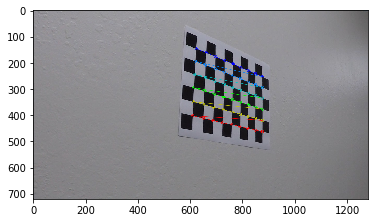

In [2]:
# Read in the calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Set up two empty arrays to hold object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Number of corners on the x axis
nx = 9
# Number of corners on the y axis
ny = 6

# Preapare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (7,5,0)
objp = np.zeros((ny*nx,3), np.float32) # 6 by 9 points in an array, each with three columns for the x, y and z coordinates of each corner

# For x and y, use numpy's mgrid function to generate the coordinates I want, z can stay as 0
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

# NOTE: mgrid returns the coordinate values for a given grid size and I'll shape those coordinates back
# into two columns, one for x and one for y

# To create the image points, I want to look at the distorted calibration image and detect the corners of the board
# the OpenCV function "findChessboardCorners" returns the corners found in a grayscale image
# so the next step would be to turn the image into grayscale and then pass it to the findChessboardCorners function
# The function takes in the grayscale image along with the dimensions of the chessboard corners, in this case 9 by 6
# last parameter is for any flags, which are none for this case

for file_name in images:    
    # Read in each image
    img = mpimg.imread(file_name)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If corners are found, append the points to the image points array
    if ret == True:
        imgpoints.append(corners)
        # And also add the prepared object points (objp) to the object points array
        objpoints.append(objp)

        # Print the corners, just to see the structure, UPDATE:  it's the same as the one on perspective_transform.ipynb
        # Where you decide the source and destination coordinates
        #print('Corners array:',corners)

        # draw the detected corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)

0


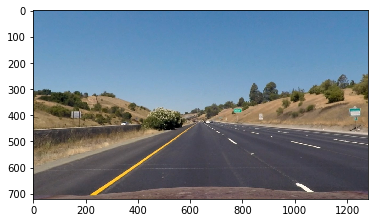

In [70]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Read in the test images
images = glob.glob('test_images/*.jpg')
undist_images = []
for file_name in images:
    # Read in each image
    img = mpimg.imread(file_name)
    # Undistort each image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Append to the undistorted images array
    undist_images.append(undist)

import random
# Select a random undistorted image
index = random.randint(0, len(undist_images))
undist = undist_images[index]

print(index)

# Display a random image just to be sure
plt.imshow(undist)
# Discard the images array?!
#images = []

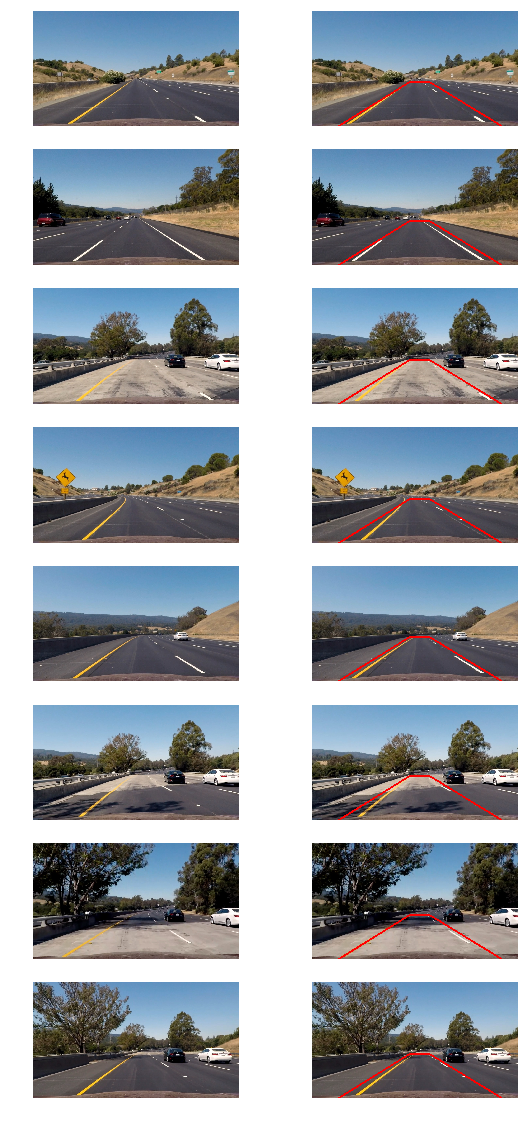

In [71]:
def trapezoid_offset_sizes(image):
    img_size = (img.shape[1], img.shape[0])
    
    # Capture the x and y size
    height = image.shape[0]
    width = image.shape[1]

    image_x_center = width / 2
    image_y_center = height / 2

    # Next we create our polygon to define which area in the image we are interested in finding lines
    imshape = image.shape
    #
    offset_y = image_y_center * 0.24
    offset_x = image_x_center * 0.10
    
    bottom_left_offset_x = width * 0.13
    bottom_right_offset_x = width * 0.08
    
    top_left_offset_x = image_x_center * 0.05
    top_right_offset_x = image_x_center * 0.14
    offset = 0
    bottom_offset_x = width * 0.03
    
    return img_size, height, width, image_x_center, image_y_center, offset_y, bottom_left_offset_x, bottom_right_offset_x, top_left_offset_x, top_right_offset_x

def draw_trapezoid_lines(image):
    
    # Width, height and offsets to help draw the trapezoid
    img_size, height, width, image_x_center, image_y_center, offset_y, bottom_left_offset_x, bottom_right_offset_x, top_left_offset_x, top_right_offset_x = trapezoid_offset_sizes(image)
  
    # Draw the lines starting from the top to the bottom
    # Line color - red
    color = [255, 0, 0]
    # Line thickness
    thickness = 10
    # Left line
    cv2.line(image, (int(round(0+bottom_left_offset_x)),height), (int(round(image_x_center-top_left_offset_x)), int(round(image_y_center+offset_y))),color,thickness)
    # Right line
    cv2.line(image, (int(round(width-bottom_right_offset_x)),height), (int(round(image_x_center+top_right_offset_x)), int(round(image_y_center+offset_y))),color,thickness)
    # Top line
    cv2.line(image, (int(round(image_x_center-top_left_offset_x)), int(round(image_y_center+offset_y))), (int(round(image_x_center+top_right_offset_x)), int(round(image_y_center+offset_y))), color,thickness )

# Set up plot
fig, axs = plt.subplots(len(undist_images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0    
for image in undist_images:
    # Copy the undistorted image
    trapezoid_lines_image = np.copy(image)
    # Draw the lines on the image
    draw_trapezoid_lines(trapezoid_lines_image)
    # Display the image with the trapezoid lines drawn on it,
    # these will be the points I will use as the perspective transform source
    #plt.imshow(trapezoid_lines_image)
    axs[i].imshow(image)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(trapezoid_lines_image)
    axs[i].axis('off')
    i += 1
# Copy the undistorted image
#trapezoid_lines_image = np.copy(undist)
# Draw the lines on the image
#process_image(trapezoid_lines_image)
# Display the image with the trapezoid lines drawn on it,
# these will be the points I will use as the perspective transform source
#plt.imshow(trapezoid_lines_image)

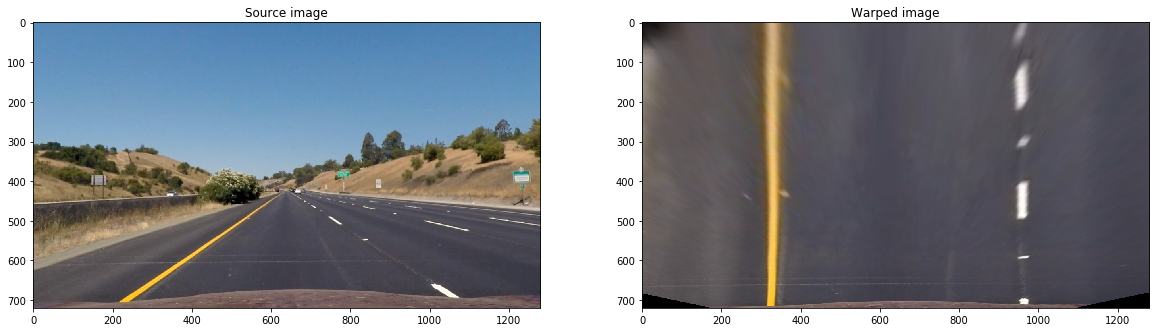

In [72]:
# Define perspective transform function
def warp(img):

    # Define calibration box in source (original) and destination (desired or warped) coordinates
    
    # Width, height and offsets to help specify the trapezoid source points
    img_size, height, width, image_x_center, image_y_center, offset_y, bottom_left_offset_x, bottom_right_offset_x, top_left_offset_x, top_right_offset_x = trapezoid_offset_sizes(img)
    offset = 350
    
    # Four source coordinates
    # top right, bottom right, bottom left, top left
    #src = np.array([[(0,height),(image_x_center-offset_x, image_y_center+offset_y), (image_x_center+offset_x, image_y_center+offset_y), (width,height)]], dtype=np.int32)
    #src = np.float32(
    #        [[0,height],
    #         [image_x_center-offset_x, image_y_center+offset_y],
    #         [image_x_center+offset_x, image_y_center+offset_y],
    #         [width,height]])
    #src = np.float32([[image_x_center+offset_x, image_y_center+offset_y],[width,height],[0,height],[image_x_center-offset_x, image_y_center+offset_y]])
    src = np.float32(
            [[image_x_center+top_right_offset_x,image_y_center+offset_y],
             [width-bottom_right_offset_x, height],
             [0+bottom_left_offset_x,height],
             [image_x_center-top_left_offset_x,image_y_center+offset_y]])
    
    src = np.float32([(image_x_center-top_left_offset_x,image_y_center+offset_y), (image_x_center+top_right_offset_x,image_y_center+offset_y), (width-bottom_right_offset_x, height), (0+bottom_left_offset_x,height)])
    
    # Four desired coordinates -- where the warped image will be placed
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])

    #dst = np.float32([[img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset], [offset, offset]])
    
    dst = np.float32([[width-offset, offset], [width-offset, height], [offset, height], [offset,offset]])
    
    top_right = [900, 1]
    bottom_right = [900, 720]
    bottom_left = [300,720] 
    top_left = [300, 1]
    
    
    #top_right = [width-bottom_right_offset_x, 1]
    #bottom_right = [width-bottom_right_offset_x, height]
    #bottom_left  = [0+bottom_left_offset_x, height]
    #top_left = [0+bottom_left_offset_x, 1]
    
    dst = np.float32([top_right, bottom_right, bottom_left,top_left])
    
    dst = np.float32([(width-450,0),(width-450,height),(450,height),(450,0)])
    #dst = np.float32([[width-bottom_offset_x, 0], [width-bottom_offset_x, height], [0+bottom_offset_x,height], [0+bottom_offset_x, 0]])
    #dst = np.float32([[img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset], [offset, offset]])
    #dst = np.float32(
    #        [[image_x_center+offset_x, image_y_center+offset_y],
    #         [width-bottom_offset_x,height],
    #         [0+bottom_offset_x,height],
    #         [image_x_center-offset_x, image_y_center+offset_y]])
    #dst = np.float32([[offset, img_size[1]-offset], [offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset]])

    #dst = np.float32([[30,img_size[0]+30],[img_size[1],img_size[0]+30],[img_size[1],30],[30,30]])
    offset_left = 600
    offset_right = 5
    dst = np.float32([ [width-offset_right, 5], [width-offset_right, height], [0+offset_left, height], [0+offset_left, 5] ])
    #dst = np.float32([ [offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
    
    dst = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]], dtype = "float32")
    
    w,h = width,height
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    
    
    # Compute the perspective transform, M
    # This function takes in four source points and four destination points and returns the mapping perspective matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Could compute the inverse also by swapping the input parameters - use to unwarp the image
    M_inverted = cv2.getPerspectiveTransform(dst, src)

    # Apply the transform M to the original image to get the warped image by calling the warp perspective function
    # This function takes in the image, the perspective matrix M, the size we want the warped image to be, and
    # how to interpolate points - fill in missing points as it warps an image - use - linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M_inverted

#image = read_image('test_images/test1.jpg')
#processed_image = process_image(image)
#processed_image = process_image(combined_binary)
#plt.imshow(processed_image)

def source_points(img):
    # Width, height and offsets to help specify the trapezoid source points
    img_size, height, width, image_x_center, image_y_center, offset_y, bottom_left_offset_x, bottom_right_offset_x, top_left_offset_x, top_right_offset_x = trapezoid_offset_sizes(img)
    # Order of points
    # top right, bottom right, bottom left, top left
    # top left, top right, bottom right, bottom left
    #src = np.float32([[image_x_center+top_right_offset_x,image_y_center+offset_y],[width-bottom_right_offset_x, height],[0+bottom_left_offset_x,height],[image_x_center-top_left_offset_x,image_y_center+offset_y]])
    src = np.float32([(73, 239), (356, 117), (475, 265), (187, 443)])
    src = np.float32([(image_x_center-top_left_offset_x,image_y_center+offset_y), (image_x_center+top_right_offset_x,image_y_center+offset_y), (width-bottom_right_offset_x, height), (0+bottom_left_offset_x,height)])
    #src = np.float32([(420, 420), (810, 420), (205, 720), (1090, 729)])
    return src

%matplotlib inline

# Perform perspective transformation
# Old perspective transform
warped_im, Minv = warp(undist)
# New perspective transform
#src = source_points(undist)
#warped_im, Minv = four_point_transform(undist, src)

# Visualize effect
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Source image')
#ax1.imshow(undist)
ax1.imshow(undist)
ax2.set_title('Warped image')
#ax2.imshow(np.rot90(warped_im,k=1,axes=(0,1)))
ax2.imshow(warped_im)

#plt.imshow(cropped_im)
#warped_im = cropped_im


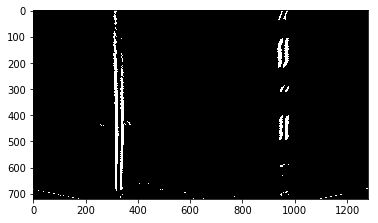

In [73]:
## Applying Sobel

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline
# Read in an image and grayscale it
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = warped_im
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh_min=20, thresh_max=100):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
        abs_sobel = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    #thresh_min = 20
    #thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    binary_output = sxbinary
    return binary_output

plt.imshow(abs_sobel_thresh(image), cmap='gray')

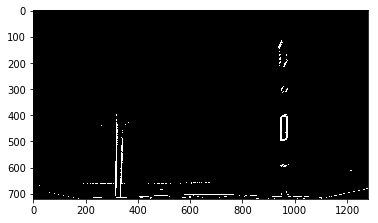

In [74]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    #abs_sobelx = np.absolute(sobelx)
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #abs_sobely = np.absolute(sobely)
    # 3) Calculate the magnitude
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradient_magnitude)/255 
    gradient_magnitude = np.uint8(gradient_magnitude/scale_factor)
    # 5) Create a binary mask where mag thresholds are met, zeros otherwise
    binary_mask = np.zeros_like(gradient_magnitude)
    binary_mask[(gradient_magnitude >= mag_thresh[0]) & (gradient_magnitude <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    binary_output = binary_mask
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')

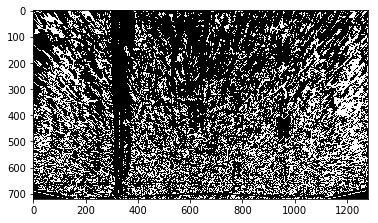

In [75]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_mask = np.zeros_like(gradient_direction)
    binary_mask[ (gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    binary_output = binary_mask
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary, cmap='gray')

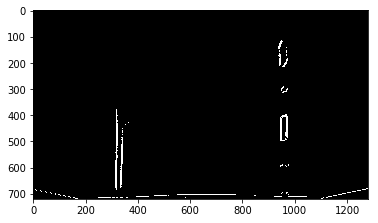

In [76]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=50, thresh_max=100)
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min=50, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap='gray')

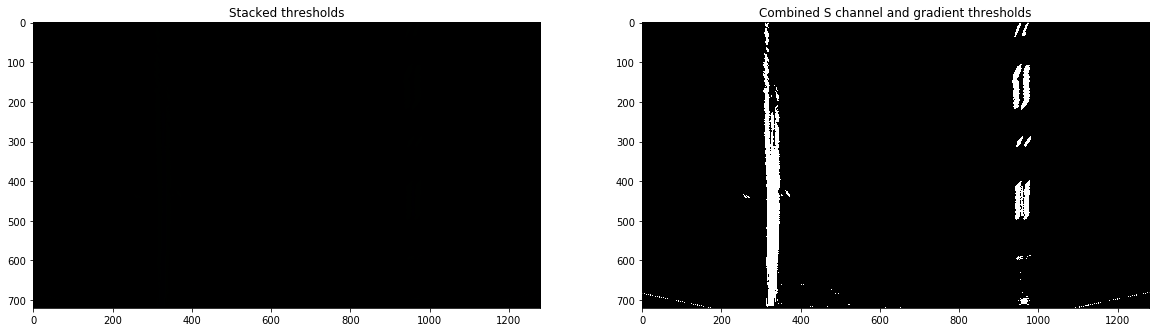

In [77]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

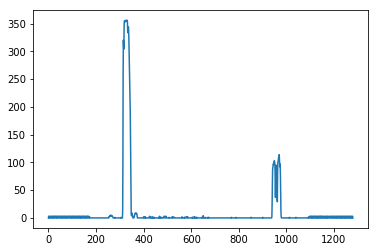

In [78]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [79]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(combined_binary.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = combined_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = combined_binary.shape[0] - (window+1)*window_height
    win_y_high = combined_binary.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

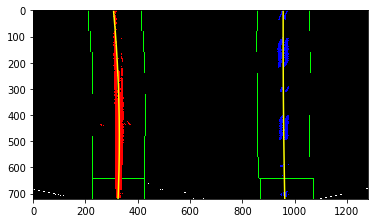

In [80]:
# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
binary_warped = combined_binary

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

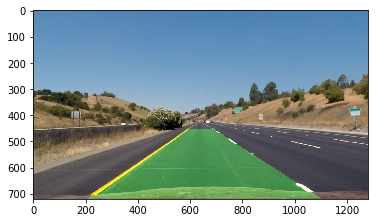

In [81]:
# Create an image to draw the lines on
warped = combined_binary
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
#undist = read_image('test_images/test1.jpg')
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)